In [193]:
import os
import torch
from torch import nn
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix
%matplotlib notebook

In [194]:
class SubMNIST(Dataset):
    def __init__(self, root, transform=None, target_transform=None):
        self.root = root
        self.transform = transform
        self.target_transform = target_transform
        self.__load_data(self.root)
        if self.transform:
            self.data = self.transform(self.data)
        if self.target_transform:
            self.label = self.target_transform(self.label)
        
    def __len__(self):
        return len(self.data)
        
    def __getitem__(self, idx):
        return self.data[idx], self.label[idx]
        
    def __load_data(self, root):
        tree = os.walk(root)
        next(tree)
        self.data, self.label = [], []
        for dirpath, dirnames, filenames in tree:
            os.chdir(dirpath)
            self.data += [read_image(filename)/255 for filename in filenames]
            self.label += [int(os.path.relpath(dirpath, root))] * len(filenames)

In [195]:
%%time
training_data = SubMNIST(
    '/home/akash/Desktop/Documents/sem6/cs671/assignment_2/Group_8/train'
)
validation_data = SubMNIST(
    '/home/akash/Desktop/Documents/sem6/cs671/assignment_2/Group_8/val'
)
test_data = SubMNIST(
    '/home/akash/Desktop/Documents/sem6/cs671/assignment_2/Group_8/test'
)

CPU times: user 2.1 s, sys: 969 ms, total: 3.07 s
Wall time: 4.4 s


In [196]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cpu device


In [197]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.hidden_layers = nn.Sequential(
            nn.Linear(28*28, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 10),
            nn.Softmax(dim=1)
        )
        
    def forward(self, X):
        X = self.flatten(X)
        return self.hidden_layers(X)

In [198]:
def train(dataloader, model, loss_fn, optimizer, threshold=1e-4):
    error, last_error = 0, -threshold * 2
    e = 0
    avg_errors = []
    accuracy = 0
    while abs(error - last_error) > threshold:
        correct = 0
        total = 0
        last_error = error
        error = 0
        print(f'Epoch {e+1}')
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            # predict
            pred = model(X)
            loss = loss_fn(pred, y)
            error += loss
            # update
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # calc metric
            correct += (pred.argmax(dim=1) == y).sum().item()
            total += len(pred)
            print(f'[{batch+1:>5d}/{len(dataloader):>5d}] loss = {error/(batch+1):.5f} | Accuracy = {correct * 100 / total:.2f}%', end='\r')
        print()
        error /= len(dataloader)
        avg_errors.append(error.item())
        accuracy = correct * 100 / total
        print(f'Delta: {abs(error - last_error):.5f}')
        print('-------------------------------\n')
        e += 1
    return e, avg_errors, accuracy
        
def test(dataloader, model, loss_fn):
    correct = 0
    total = 0
    error = 0
    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            # predict
            pred = model(X)
            error += loss_fn(pred, y)
            # calc metric
            correct += (pred.argmax(dim=1) == y).sum().item()
            total += len(pred)
            print(f'[{batch+1:>5d}/{len(dataloader):>5d}] loss = {error/(batch+1):.5f} | Accuracy = {correct * 100 / total:.2f}%', end='\r')
    return correct * 100 / total

In [199]:
loss_fn = nn.CrossEntropyLoss()

In [120]:
%%time
sgd_model = NeuralNetwork().to(device)
batch_size = 1
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(validation_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
optimizer = torch.optim.SGD(sgd_model.parameters(), lr=1e-3)
sgd_e, sgd_errors, sgd_train_acc = train(train_dataloader, sgd_model, loss_fn, optimizer)

Epoch 1
[11385/11385] loss = 2.29797 | Accuracy = 14.26%
Delta: 2.29797
-------------------------------

Epoch 2
[11385/11385] loss = 2.28124 | Accuracy = 20.00%%
Delta: 0.01673
-------------------------------

Epoch 3
[11385/11385] loss = 2.25367 | Accuracy = 25.60%
Delta: 0.02757
-------------------------------

Epoch 4
[11385/11385] loss = 2.13328 | Accuracy = 32.79%
Delta: 0.12039
-------------------------------

Epoch 5
[11385/11385] loss = 1.81285 | Accuracy = 72.90%%
Delta: 0.32042
-------------------------------

Epoch 6
[11385/11385] loss = 1.62544 | Accuracy = 87.54%%
Delta: 0.18742
-------------------------------

Epoch 7
[11385/11385] loss = 1.56999 | Accuracy = 91.08%%
Delta: 0.05544
-------------------------------

Epoch 8
[11385/11385] loss = 1.55152 | Accuracy = 92.03%%
Delta: 0.01848
-------------------------------

Epoch 9
[11385/11385] loss = 1.54080 | Accuracy = 93.06%%
Delta: 0.01071
-------------------------------

Epoch 10
[11385/11385] loss = 1.53391 | Accuracy 

In [121]:
sgd_val_acc = test(val_dataloader, sgd_model, loss_fn)

In [122]:
sgd_test_acc = test(test_dataloader, sgd_model, loss_fn)

In [48]:
%%time
vgd_model = NeuralNetwork().to(device)
batch_size = len(training_data)
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(validation_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
optimizer = torch.optim.SGD(vgd_model.parameters(), lr=1)
vgd_e, vgd_errors, vgd_train_acc = train(train_dataloader, vgd_model, loss_fn, optimizer)

Epoch 1
[    1/    1] loss = 2.30285 | Accuracy = 19.96%
Delta: 2.30285
-------------------------------

Epoch 2
[    1/    1] loss = 2.30140 | Accuracy = 20.00%
Delta: 0.00145
-------------------------------

Epoch 3
[    1/    1] loss = 2.29995 | Accuracy = 20.00%
Delta: 0.00145
-------------------------------

Epoch 4
[    1/    1] loss = 2.29850 | Accuracy = 20.00%
Delta: 0.00145
-------------------------------

Epoch 5
[    1/    1] loss = 2.29705 | Accuracy = 20.00%
Delta: 0.00145
-------------------------------

Epoch 6
[    1/    1] loss = 2.29559 | Accuracy = 20.00%
Delta: 0.00146
-------------------------------

Epoch 7
[    1/    1] loss = 2.29412 | Accuracy = 20.00%
Delta: 0.00148
-------------------------------

Epoch 8
[    1/    1] loss = 2.29262 | Accuracy = 20.00%
Delta: 0.00150
-------------------------------

Epoch 9
[    1/    1] loss = 2.29110 | Accuracy = 20.00%
Delta: 0.00152
-------------------------------

Epoch 10
[    1/    1] loss = 2.28954 | Accuracy = 20.0

In [200]:
vgd_val_acc = test(val_dataloader, vgd_model, loss_fn)

In [201]:
vgd_test_acc = test(test_dataloader, vgd_model, loss_fn)

In [52]:
batch_size = 32
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(validation_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [127]:
%%time
nag_model = NeuralNetwork().to(device)
optimizer = torch.optim.SGD(nag_model.parameters(), lr=1e-3, momentum=0.9, nesterov=True)
nag_e, nag_errors, nag_train_acc = train(train_dataloader, nag_model, loss_fn, optimizer)

Epoch 1
[  356/  356] loss = 2.29876 | Accuracy = 19.91%
Delta: 2.29876
-------------------------------

Epoch 2
[  356/  356] loss = 2.29193 | Accuracy = 23.29%
Delta: 0.00683
-------------------------------

Epoch 3
[  356/  356] loss = 2.28346 | Accuracy = 27.69%
Delta: 0.00848
-------------------------------

Epoch 4
[  356/  356] loss = 2.27056 | Accuracy = 20.98%
Delta: 0.01289
-------------------------------

Epoch 5
[  356/  356] loss = 2.24697 | Accuracy = 20.00%
Delta: 0.02359
-------------------------------

Epoch 6
[  356/  356] loss = 2.21579 | Accuracy = 20.00%
Delta: 0.03118
-------------------------------

Epoch 7
[  356/  356] loss = 2.19481 | Accuracy = 20.00%
Delta: 0.02098
-------------------------------

Epoch 8
[  356/  356] loss = 2.17229 | Accuracy = 20.20%
Delta: 0.02252
-------------------------------

Epoch 9
[  356/  356] loss = 2.12843 | Accuracy = 33.47%
Delta: 0.04386
-------------------------------

Epoch 10
[  356/  356] loss = 2.05553 | Accuracy = 38.9

In [128]:
nag_val_acc = test(val_dataloader, nag_model, loss_fn)

In [129]:
nag_test_acc = test(test_dataloader, nag_model, loss_fn)

In [178]:
%%time
rmsp_model = NeuralNetwork().to(device)
optimizer = torch.optim.RMSprop(rmsp_model.parameters(), lr=1e-3, alpha=0.99)
rmsp_e, rmsp_errors, rmsp_train_acc = train(train_dataloader, rmsp_model, loss_fn, optimizer)

Epoch 1
[  356/  356] loss = 1.60125 | Accuracy = 87.33%
Delta: 1.60125
-------------------------------

Epoch 2
[  356/  356] loss = 1.52621 | Accuracy = 93.79%
Delta: 0.07504
-------------------------------

Epoch 3
[  356/  356] loss = 1.51568 | Accuracy = 94.68%
Delta: 0.01053
-------------------------------

Epoch 4
[  356/  356] loss = 1.51045 | Accuracy = 95.15%
Delta: 0.00523
-------------------------------

Epoch 5
[  356/  356] loss = 1.50506 | Accuracy = 95.63%
Delta: 0.00539
-------------------------------

Epoch 6
[  356/  356] loss = 1.50186 | Accuracy = 96.05%
Delta: 0.00320
-------------------------------

Epoch 7
[  356/  356] loss = 1.49843 | Accuracy = 96.30%
Delta: 0.00343
-------------------------------

Epoch 8
[  356/  356] loss = 1.49565 | Accuracy = 96.62%
Delta: 0.00277
-------------------------------

Epoch 9
[  356/  356] loss = 1.49319 | Accuracy = 96.86%
Delta: 0.00246
-------------------------------

Epoch 10
[  356/  356] loss = 1.49093 | Accuracy = 97.0

In [181]:
rmsp_val_acc = test(val_dataloader, rmsp_model, loss_fn)

In [182]:
rmsp_test_acc = test(test_dataloader, rmsp_model, loss_fn)

In [186]:
%%time
adam_model = NeuralNetwork().to(device)
optimizer = torch.optim.Adam(adam_model.parameters(), lr=1e-3, betas=(0.9, 0.999), eps=1e-8)
adam_e, adam_errors, adam_train_acc = train(train_dataloader, adam_model, loss_fn, optimizer)

Epoch 1
[  356/  356] loss = 1.78006 | Accuracy = 70.22%
Delta: 1.78006
-------------------------------

Epoch 2
[  356/  356] loss = 1.55305 | Accuracy = 91.55%
Delta: 0.22702
-------------------------------

Epoch 3
[  356/  356] loss = 1.52167 | Accuracy = 94.21%
Delta: 0.03138
-------------------------------

Epoch 4
[  356/  356] loss = 1.51339 | Accuracy = 94.98%%
Delta: 0.00828
-------------------------------

Epoch 5
[  356/  356] loss = 1.50822 | Accuracy = 95.50%
Delta: 0.00517
-------------------------------

Epoch 6
[  356/  356] loss = 1.50596 | Accuracy = 95.58%
Delta: 0.00226
-------------------------------

Epoch 7
[  356/  356] loss = 1.50043 | Accuracy = 96.16%
Delta: 0.00553
-------------------------------

Epoch 8
[  356/  356] loss = 1.49785 | Accuracy = 96.36%%
Delta: 0.00258
-------------------------------

Epoch 9
[  356/  356] loss = 1.49893 | Accuracy = 96.31%
Delta: 0.00108
-------------------------------

Epoch 10
[  356/  356] loss = 1.49594 | Accuracy = 96

In [187]:
adam_val_acc = test(val_dataloader, adam_model, loss_fn)

In [188]:
adam_test_acc = test(test_dataloader, adam_model, loss_fn)

In [141]:
pd.DataFrame([
    ['Stochastic gradient descent', sgd_e],
    ['Vanilla gradient descent', vgd_e],
    ['NAG', nag_e],
    ['RMSProp', rmsp_e],
    ['Adam', adam_e],
], columns=['Optimizer', 'Epochs']).set_index('Optimizer')

,Epochs
Optimizer,
Stochastic gradient descent,50
Vanilla gradient descent,2
NAG,76
RMSProp,3
Adam,21


<IPython.core.display.Javascript object>


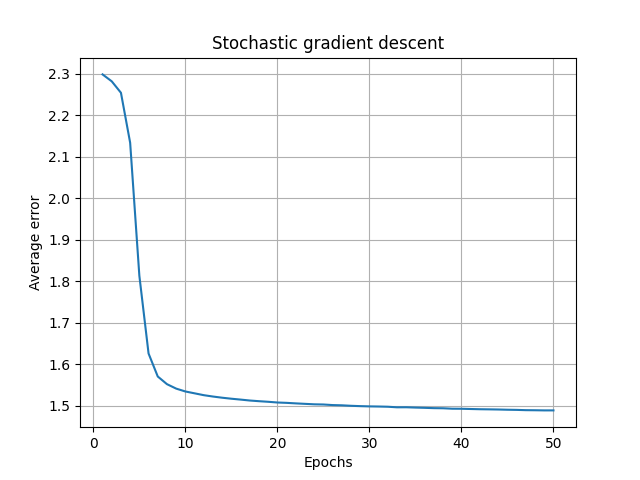

In [142]:
plt.grid(True)
plt.title('Stochastic gradient descent')
plt.ylabel('Average error')
plt.xlabel('Epochs')
plt.plot(range(1, sgd_e + 1), sgd_errors)

<IPython.core.display.Javascript object>


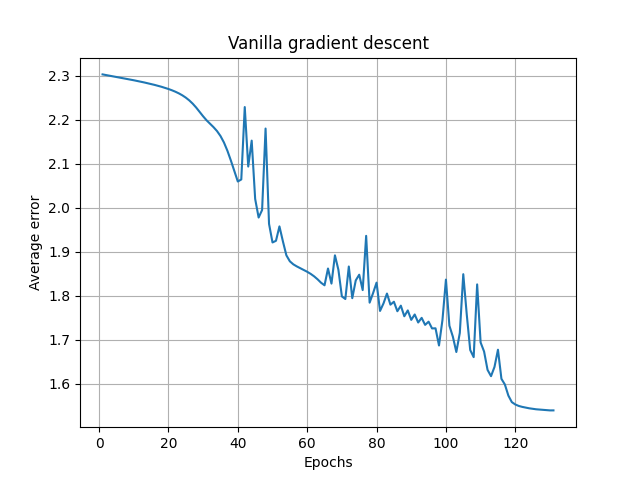

In [51]:
plt.grid(True)
plt.title('Vanilla gradient descent')
plt.ylabel('Average error')
plt.xlabel('Epochs')
plt.plot(range(1, vgd_e + 1), vgd_errors)

<IPython.core.display.Javascript object>


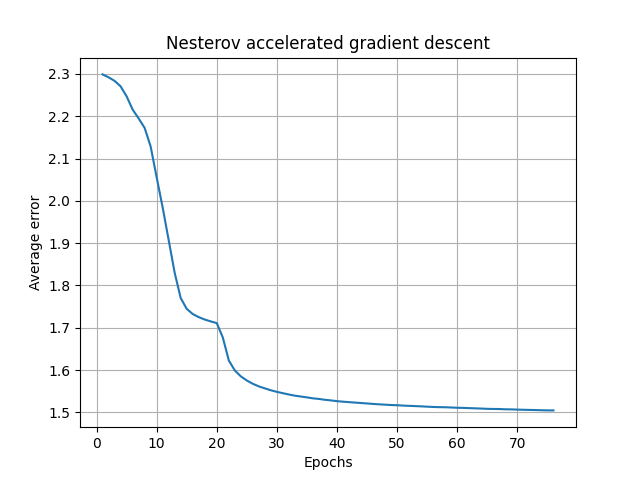

In [144]:
plt.grid(True)
plt.title('Nesterov accelerated gradient descent')
plt.ylabel('Average error')
plt.xlabel('Epochs')
plt.plot(range(1, nag_e + 1), nag_errors)

<IPython.core.display.Javascript object>


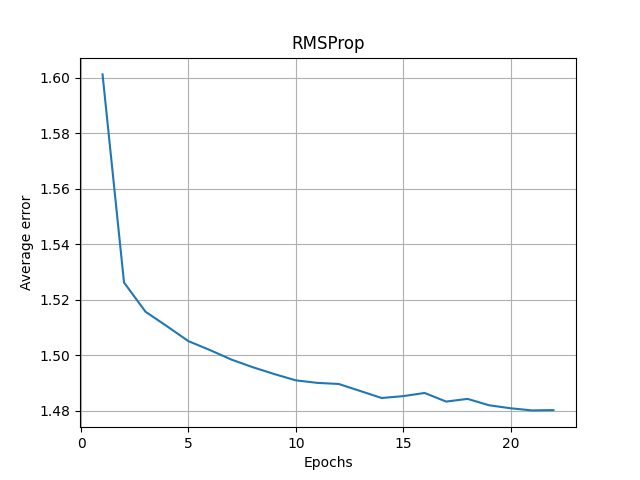

In [191]:
plt.grid(True)
plt.title('RMSProp')
plt.ylabel('Average error')
plt.xlabel('Epochs')
plt.plot(range(1, rmsp_e + 1), rmsp_errors)

<IPython.core.display.Javascript object>


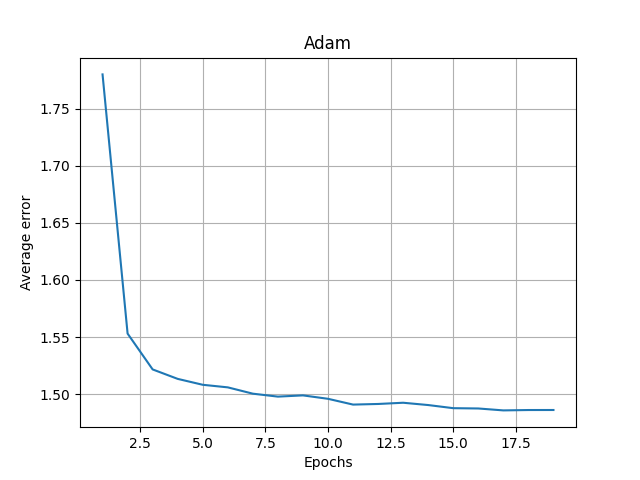

In [192]:
plt.grid(True)
plt.title('Adam')
plt.ylabel('Average error')
plt.xlabel('Epochs')
plt.plot(range(1, adam_e + 1), adam_errors)

In [147]:
pd.DataFrame([
    ['Stochastic gradient descent', sgd_train_acc, sgd_val_acc],
    ['Vanilla gradient descent', vgd_train_acc, vgd_val_acc],
    ['NAG', nag_train_acc, nag_val_acc],
    ['RMSProp', rmsp_train_acc, rmsp_val_acc],
    ['Adam', adam_train_acc, adam_val_acc],
], columns=['Optimizer', 'Training accuracy', 'Validation accuracy']).set_index('Optimizer')

,Training accuracy,Validation accuracy
Optimizer,,
Stochastic gradient descent,97.452789,95.467721
Vanilla gradient descent,20.000000,20.000000
NAG,96.144049,94.914361
RMSProp,20.000000,20.000000
Adam,97.435222,96.653491


In [207]:
train_dataloader = DataLoader(training_data, batch_size=len(training_data), shuffle=False)
cmat = None
for X, y in train_dataloader:
    pred = rmsp_model(X)
    cmat = confusion_matrix(y, pred.argmax(dim=1))

In [208]:
print(f'Training accuracy: {rmsp_train_acc:.2f}%')
print('Training confusion matrix:\n', cmat)

Training accuracy: 98.09%
Training confusion matrix:
 [[2249   16    4    6    2]
 [   4 2240    1   19   13]
 [   1    2 2247    2   25]
 [   4   20    0 2244    9]
 [   2   23   12    6 2234]]


In [218]:
y.unique()

tensor([1, 3, 4, 8, 9])

In [210]:
test_dataloader = DataLoader(test_data, batch_size=len(test_data), shuffle=False)
cmat = None
for X, y in test_dataloader:
    pred = rmsp_model(X)
    cmat = confusion_matrix(y, pred.argmax(dim=1))

In [211]:
print(f'Test accuracy: {rmsp_test_acc:.2f}%')
print('Test confusion matrix:\n', cmat)

Test accuracy: 97.58%
Test confusion matrix:
 [[748   8   0   3   0]
 [  1 742   1  11   4]
 [  0   1 742   2  14]
 [  1  13   3 736   6]
 [  3   6  12   3 735]]


In [110]:
class AutoEncoder(nn.Module):
    def __init__(self, noise=False):
        super().__init__()
        self.noise = noise
        self.flatten = nn.Flatten()
        self.encode = nn.Sequential(
            nn.Linear(28*28, 64),
            nn.Sigmoid()
        )
        self.decode = nn.Sequential(
            nn.Linear(64, 28*28),
            nn.Sigmoid()
        )
        
    def forward(self, X):
        if self.noise:
            X += torch.bernoulli(torch.ones_like(x) * 0.2) * torch.randn_like(x)
        X = self.flatten(X)
        X = self.encode(X)
        return self.decode(X)

In [111]:
def train(dataloader, model, loss_fn, optimizer, threshold=1e-4):
    error, last_error = 0, -threshold * 2
    e = 0
    avg_errors = []
    while abs(error - last_error) > threshold:
        last_error = error
        error = 0
        print(f'Epoch {e+1}')
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            # predict
            pred = model(X)
            loss = loss_fn(pred, model.flatten(X))
            error += loss
            # update
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            print(f'[{batch+1:>5d}/{len(dataloader):>5d}] loss = {error/(batch+1):.5f}', end='\r')
        print()
        error /= len(dataloader)
        avg_errors.append(error.item())
        print(f'Delta: {abs(error - last_error):.5f}')
        print('-------------------------------\n')
        e += 1
    return e, avg_errors
        
def test(dataloader, model, loss_fn):
    error = 0
    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            # predict
            pred = model(X)
            loss = loss_fn(pred, y)
            error += loss
            print(f'[{batch+1:>5d}/{len(dataloader):>5d}] loss = {error/(batch+1):.5f}', end='\r')
        error /= len(dataloader)
    return error.item()

# def test(dataloader, model, loss_fn):
#     error = 0
#     with torch.no_grad():
#         for batch, (X, y) in enumerate(dataloader):
#             X, y = X.to(device), y.to(device)
#             # predict
#             pred = model(X)
#             error += loss_fn(pred, y)
#             print(f'[{batch+1:>5d}/{len(dataloader):>5d}] loss = {error/(batch+1):.5f}', end='\r')
#     return error

In [15]:
%%time
batch_size = 32
model = AutoEncoder().to(device)
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.999), eps=1e-8)
adam_e, adam_errors = train(train_dataloader, model, loss_fn, optimizer)

Epoch 1
[  356/  356] loss = 0.06641
Delta: 0.06641
-------------------------------

Epoch 2
[  356/  356] loss = 0.04963
Delta: 0.01679
-------------------------------

Epoch 3
[  356/  356] loss = 0.04090
Delta: 0.00872
-------------------------------

Epoch 4
[  356/  356] loss = 0.03551
Delta: 0.00540
-------------------------------

Epoch 5
[  356/  356] loss = 0.03164
Delta: 0.00387
-------------------------------

Epoch 6
[  356/  356] loss = 0.02848
Delta: 0.00315
-------------------------------

Epoch 7
[  356/  356] loss = 0.02587
Delta: 0.00261
-------------------------------

Epoch 8
[  356/  356] loss = 0.02373
Delta: 0.00215
-------------------------------

Epoch 9
[  356/  356] loss = 0.02190
Delta: 0.00183
-------------------------------

Epoch 10
[  356/  356] loss = 0.02030
Delta: 0.00159
-------------------------------

Epoch 11
[  356/  356] loss = 0.01895
Delta: 0.00135
-------------------------------

Epoch 12
[  356/  356] loss = 0.01779
Delta: 0.00116
----------

In [112]:
%%time
batch_size = 32
denoise_model = AutoEncoder(noise=True).to(device)
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(denoise_model.parameters(), lr=1e-3, betas=(0.9, 0.999), eps=1e-8)
adam_e, adam_errors = train(train_dataloader, denoise_model, loss_fn, optimizer)

Epoch 1
[  356/  356] loss = 0.27161
Delta: 0.27161
-------------------------------

Epoch 2
[  356/  356] loss = 0.25885
Delta: 0.01276
-------------------------------

Epoch 3
[  356/  356] loss = 0.25340
Delta: 0.00546
-------------------------------

Epoch 4
[  356/  356] loss = 0.25085
Delta: 0.00254
-------------------------------

Epoch 5
[  356/  356] loss = 0.24436
Delta: 0.00649
-------------------------------

Epoch 6
[  356/  356] loss = 0.24295
Delta: 0.00141
-------------------------------

Epoch 7
[  356/  356] loss = 0.23615
Delta: 0.00680
-------------------------------

Epoch 8
[  356/  356] loss = 0.23562
Delta: 0.00053
-------------------------------

Epoch 9
[  356/  356] loss = 0.23383
Delta: 0.00179
-------------------------------

Epoch 10
[  356/  356] loss = 0.23153
Delta: 0.00230
-------------------------------

Epoch 11
[  356/  356] loss = 0.22970
Delta: 0.00183
-------------------------------

Epoch 12
[  356/  356] loss = 0.22890
Delta: 0.00080
----------

In [18]:
for x in model.parameters():
    W = x.data
    break

In [36]:
import numpy as np

<IPython.core.display.Javascript object>


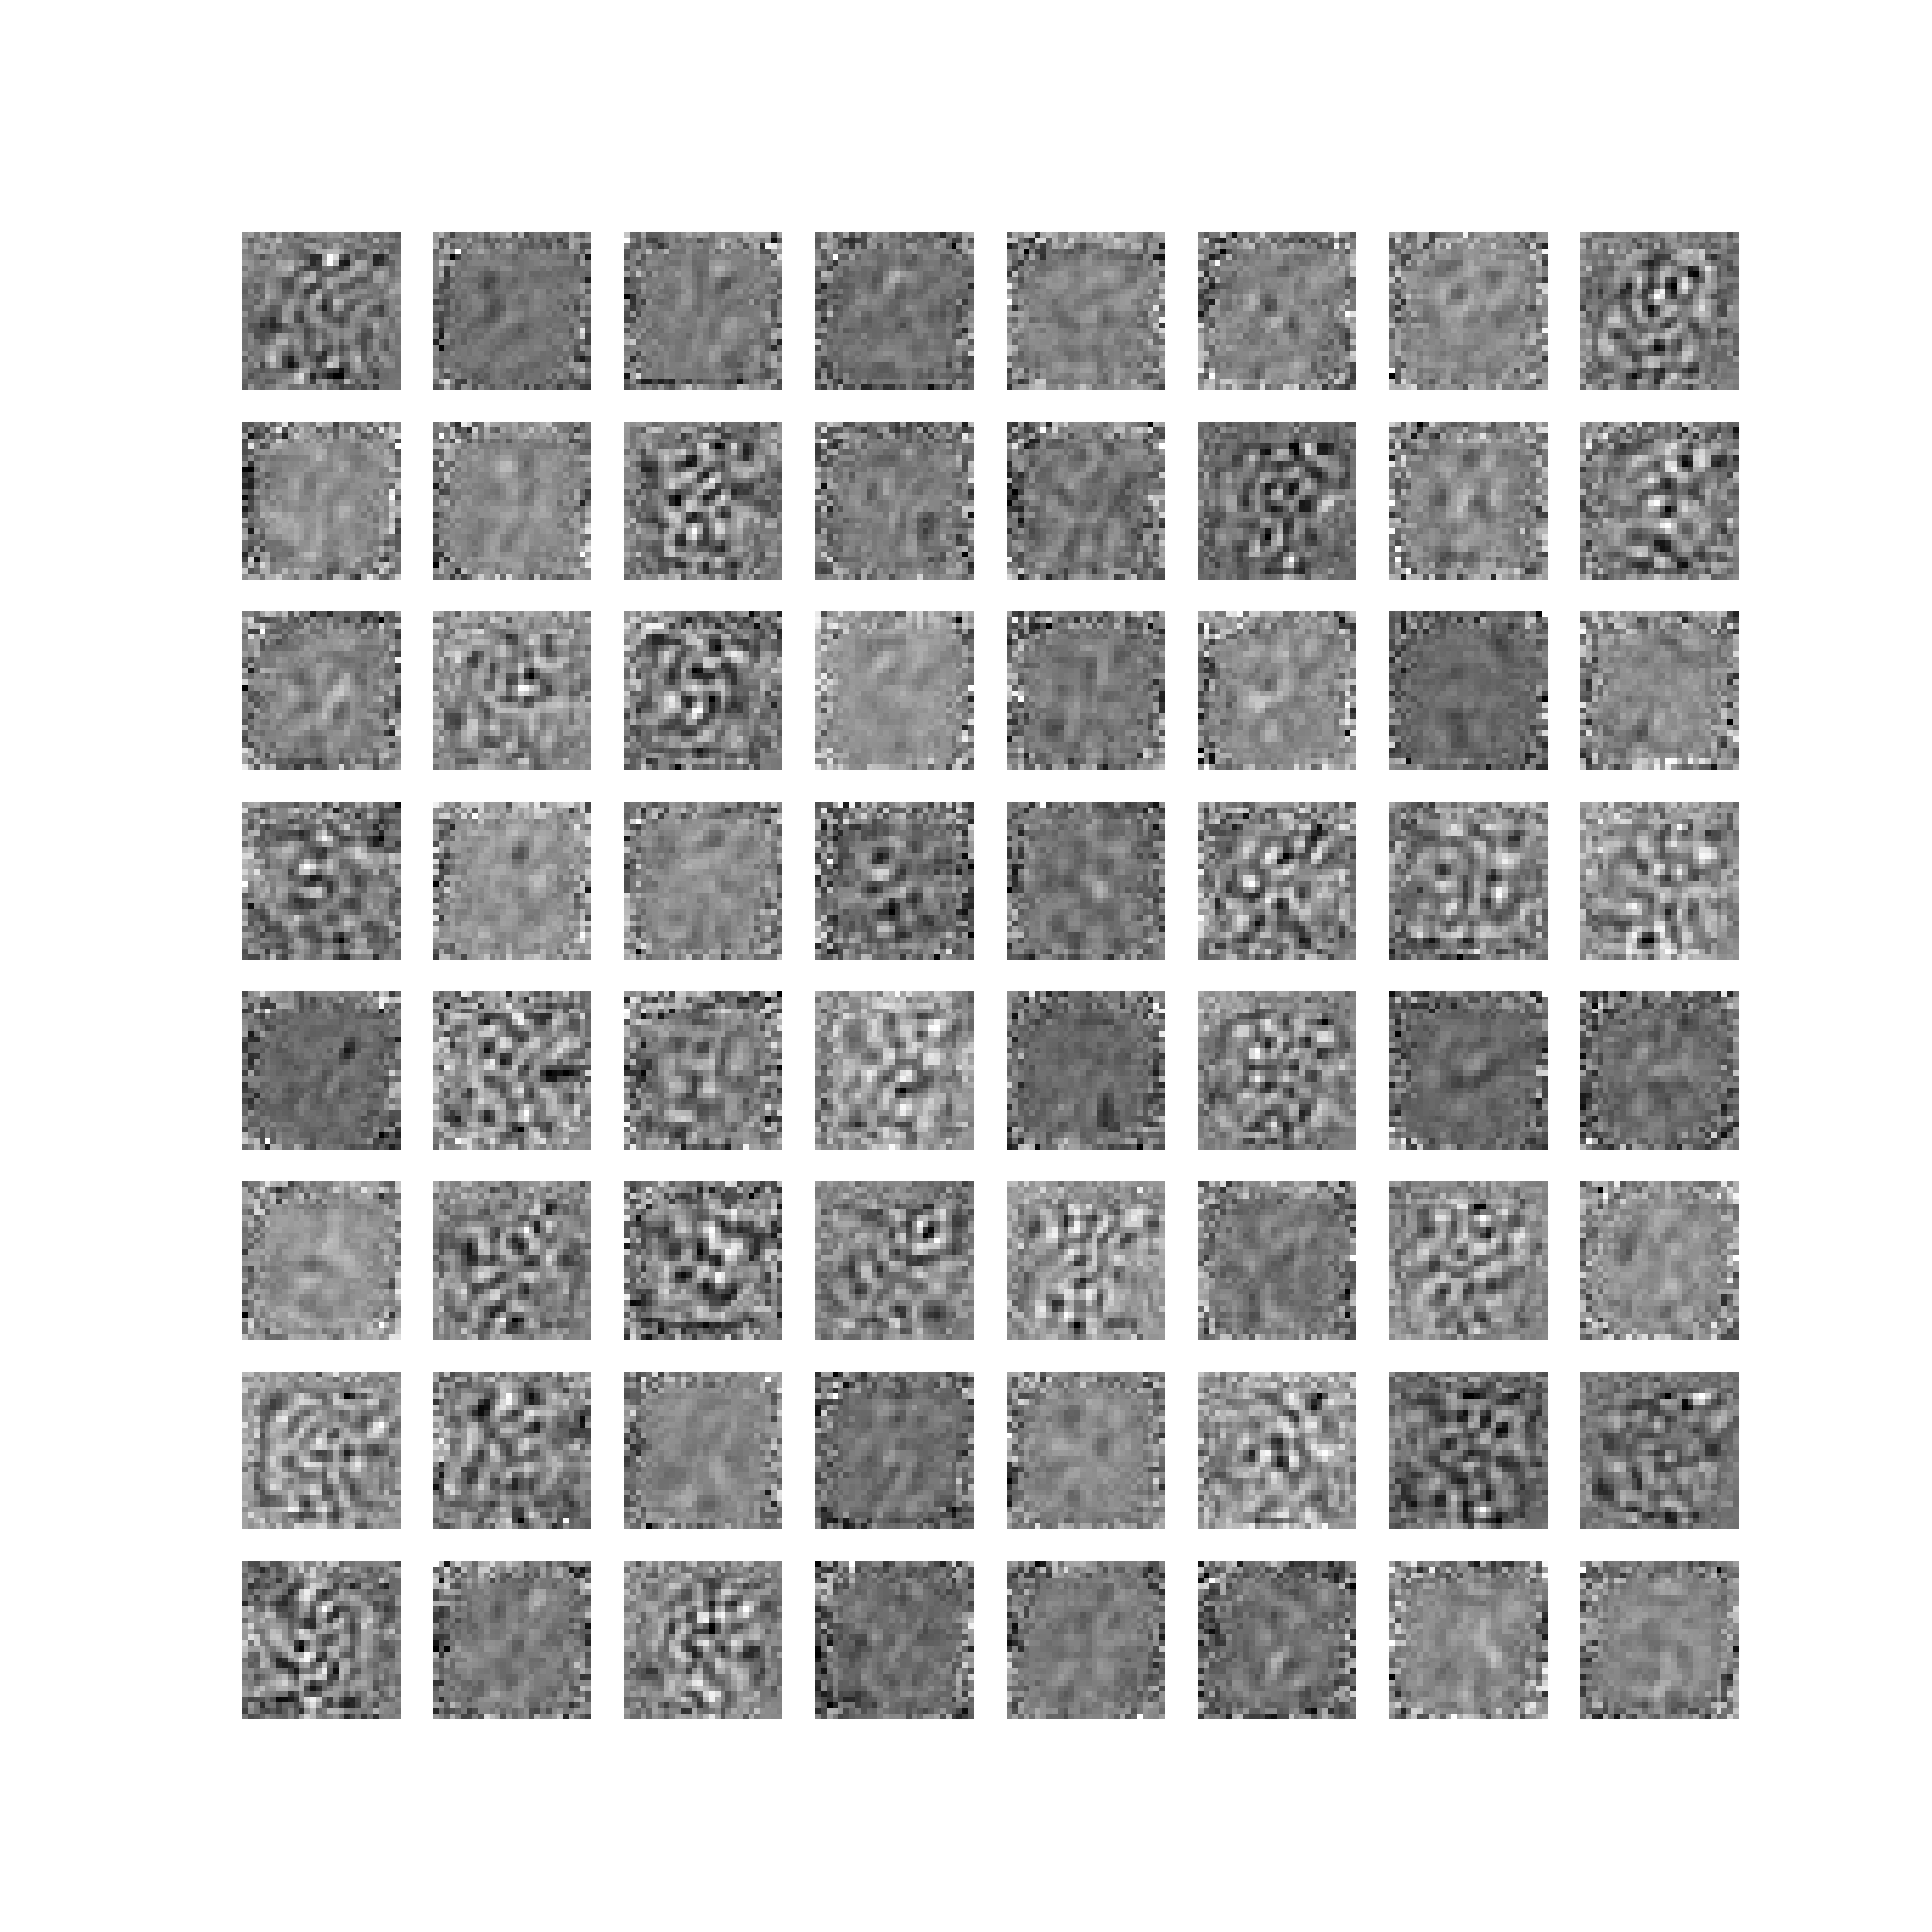

In [57]:
r = int(np.ceil(np.sqrt(W.shape[0])))
c = int(np.sqrt(W.shape[0]))
fig = plt.figure(figsize=(20, int(20 * r / c)))
for i, w in enumerate(W):
    ax = fig.add_subplot(r, c, i+1)
    ax.set_axis_off()
    w_scaled = (w - w.min()) / (w.max() - w.min())
    plt.imshow(w_scaled.reshape(28,28), cmap='gray')

<IPython.core.display.Javascript object>


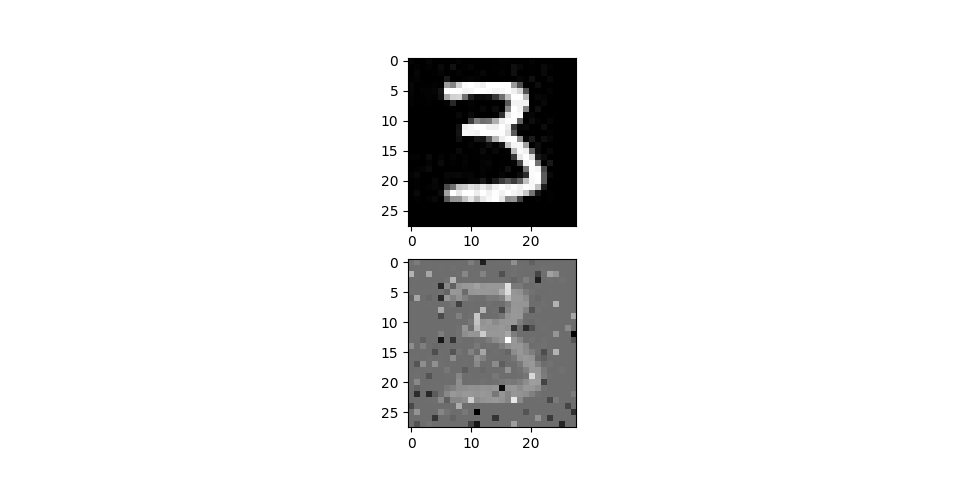

In [116]:
for X, y in train_dataloader:
    x = X[0]
    fig = plt.figure(figsize=plt.figaspect(0.5))
    ax = fig.add_subplot(2, 1, 1)
    ax.imshow(x.reshape(28,28), cmap='gray')
    ax = fig.add_subplot(2, 1, 2)
    ax.imshow((x + torch.bernoulli(torch.ones_like(x) * 0.2) * torch.randn_like(x)).reshape(28,28), cmap='gray')
    break

tensor([[[ 0.0000,  0.0000,  0.0000, -0.0000, -0.0000,  0.0194, -0.0000,
           0.0000,  0.3596, -1.2520,  0.0000, -0.0000, -0.0000, -0.5826,
          -0.0000, -0.0000, -0.0000,  0.0000, -0.0000,  0.0000,  0.0000,
           1.0232, -0.0000, -0.0000, -0.0000, -0.0000,  0.0000, -0.0000],
         [ 0.0000,  0.0000, -0.0000,  0.2799, -0.0000, -0.0000, -0.0000,
           0.0000,  0.0000,  2.0858, -0.0000, -0.5971,  0.0000,  0.0000,
          -0.0000, -0.0000,  0.0000, -0.0000, -1.5413,  0.0000, -0.0000,
          -0.0000, -0.0000,  0.0000,  0.0000,  0.0000, -0.0000, -0.0000],
         [-0.0000,  0.6544,  0.0000,  0.0000,  0.0000, -0.0000, -0.0000,
          -0.0000, -0.0000,  1.2240,  0.0000,  0.0000, -0.0000, -0.0000,
           0.0000,  0.0000, -0.0000, -0.0000, -0.0688, -0.0000, -0.0000,
          -0.0000,  0.0000,  0.0000,  0.0000, -0.0000,  0.0000, -0.0000],
         [ 0.0000, -0.0000,  0.0000,  0.6945,  0.0000,  0.0000,  0.0000,
           3.0690, -0.0000, -0.0000,  0.0000,  0

In [59]:
import numpy as np

In [100]:
def f(x, y):
    return 1 / (1 + np.exp(-x-y))

In [101]:
x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)
Z = f(X, Y)

<IPython.core.display.Javascript object>


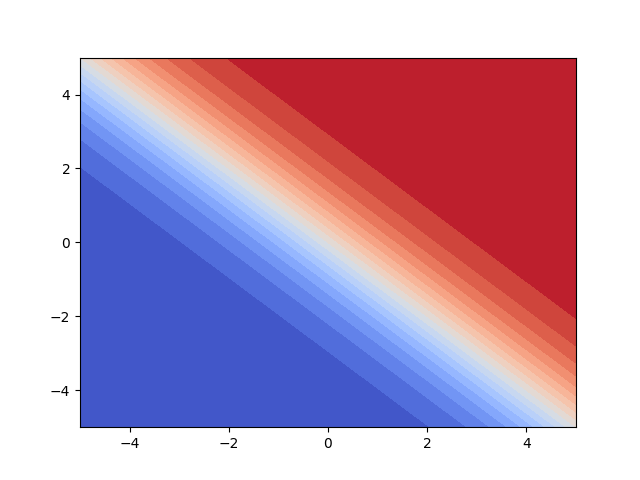

In [102]:
plt.contourf(X, Y, Z, 20, cmap='coolwarm');